In [2]:
#Tay Xun Yang: BT4014 Assignment 2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as sm
from statsmodels.tsa.api import VAR
import warnings
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")

#import sales data
df = pd.read_csv('assignment2_data.csv')
df.set_index('week',drop=True,inplace=True)

# 1) Check if Time Series Data is Stationary

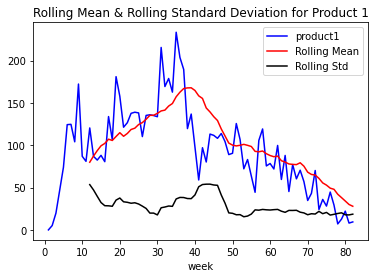

Statistical Test:
ADF test results:
Test Statistic         -2.100289
p-value                 0.244398
Critical Value (1%)    -3.514869
Critical Value (5%)    -2.898409
Critical Value (10%)   -2.586439
dtype: float64


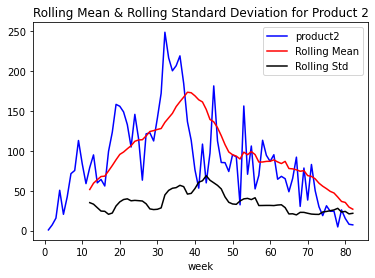

Statistical Test:
ADF test results:
Test Statistic         -2.195769
p-value                 0.207785
Critical Value (1%)    -3.514869
Critical Value (5%)    -2.898409
Critical Value (10%)   -2.586439
dtype: float64


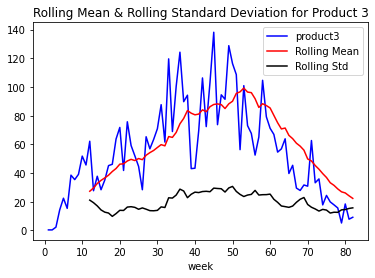

Statistical Test:
ADF test results:
Test Statistic         -2.267569
p-value                 0.182641
Critical Value (1%)    -3.514869
Critical Value (5%)    -2.898409
Critical Value (10%)   -2.586439
dtype: float64


In [3]:
def check_stationary(sales_data, product): 
    #Visually check the stationarity
    plt.clf() 
    sales_data.plot(color = 'blue')
    rolling_mean = sales_data.rolling(window = 12).mean()
    rolling_std = sales_data.rolling(window = 12).std()
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation for Product ' + product)
    plt.show()
    #ADF test
    print('Statistical Test:')
    print('ADF test results:')
    adftest = adfuller(sales_data)
    adfoutput = pd.Series(adftest[0:2], index=['Test Statistic','p-value'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    print (adfoutput)

check_stationary(df['product1'], "1")
check_stationary(df['product2'], "2")
check_stationary(df['product3'], "3")

### Time Series Plot
As the mean and variance of Products 1, 2, and 3 are not constant,  all three products are not stationary.

### ADF Result
The p-value of the ADF test for Product 1, 2 and 3 is more than 0.05. Thus, we fail to reject the null hypothesis and conclude that the all 3 products have a unit root, meaning they are not stationary.

### Differencing
As all three products are not stationary, I will use first-order difference on all 3 products and re-run the ADF test

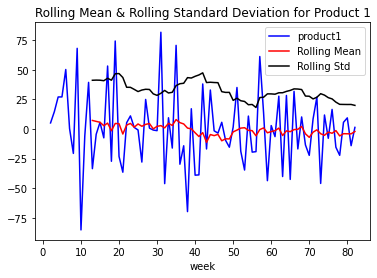

Statistical Test:
ADF test results:
Test Statistic         -1.300689e+01
p-value                 2.616392e-24
Critical Value (1%)    -3.514869e+00
Critical Value (5%)    -2.898409e+00
Critical Value (10%)   -2.586439e+00
dtype: float64


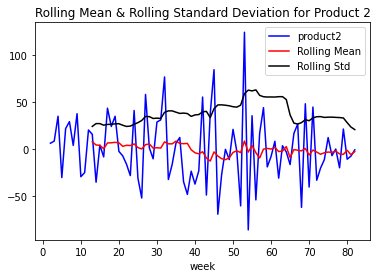

Statistical Test:
ADF test results:
Test Statistic         -5.224740
p-value                 0.000008
Critical Value (1%)    -3.521980
Critical Value (5%)    -2.901470
Critical Value (10%)   -2.588072
dtype: float64


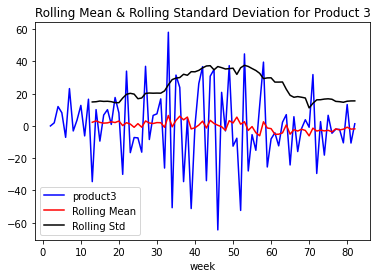

Statistical Test:
ADF test results:
Test Statistic         -1.459518e+01
p-value                 4.251821e-27
Critical Value (1%)    -3.514869e+00
Critical Value (5%)    -2.898409e+00
Critical Value (10%)   -2.586439e+00
dtype: float64


In [4]:
df_diff = df.diff().dropna()
# 1st Differencing
check_stationary(df_diff['product1'], "1")
check_stationary(df_diff['product2'], "2")
check_stationary(df_diff['product3'], "3")

### Time Series Plot After First-Order Differencing
As the mean and variance of Products 1, 2, and 3 are constant, it suggest that all 3 products are stationary.

### ADF Result After First-Order Differencing
The p-value of the ADF test for Product 1, 2 and 3 are all less than 0.05. Thus, we can reject the null hypothesis and conclude that none of the products have a unit root, meaning they are stationary.


#  2 VAR Model Order

In [5]:
#Model Determination
model = VAR(df_diff)
model.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,20.14,20.24,5.601e+08,20.18
1,19.49*,19.87*,2.914e+08*,19.64*
2,19.53,20.20,3.041e+08,19.80
3,19.51,20.47,3.003e+08,19.89
4,19.54,20.78,3.088e+08,20.03
5,19.67,21.20,3.568e+08,20.28
6,19.78,21.59,4.039e+08,20.50
7,19.68,21.79,3.762e+08,20.52
8,19.73,22.12,4.064e+08,20.68
9,19.66,22.33,3.945e+08,20.72


In the above output, the BIC drops to lowest at lag 1,thus order of VAR = 1

In [14]:
#Model Estimation
result = model.fit(1)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Mar, 2022
Time:                     12:11:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    19.8602
Nobs:                     80.0000    HQIC:                   19.6461
Log likelihood:          -1108.66    FPE:                2.95190e+08
AIC:                      19.5029    Det(Omega_mle):     2.54996e+08
--------------------------------------------------------------------
Results for equation product1
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.086509         3.355517            0.026           0.979
L1.product1        -0.386312         0.110623           -3.492           0.000
L1.product2         0.054495         0.106297            0.513   

#  3 Diagnose VAR Model 

In [7]:
#Model diagnosis
def write_results(result, columns):
    print("================test_whiteness================\n")
    print(result.test_whiteness(10).summary())
    print("================stable================\n")
    print(result.is_stable())
    print("================results.roots()================\n")
    for r in result.roots:
    #print(result.roots)
        print(r)
    print("\n================granger causality================\n")
    for V1 in columns:
        for V2 in columns:
            print("Granger test: "+V2+"-->"+V1+"\n")
            print(result.test_causality(V1, [V2],kind='f').summary())
            print("\n")

columns = df_diff.columns.values.tolist()
write_results(result, columns)

================test_whiteness================

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         100.4          103.0   0.071 81
----------------------------------------
================stable================

True
================results.roots()================

-3.5250959674134883
-2.0527296027636037
-1.7643487379485907

================granger causality================

Granger test: product1-->product1

Granger causality F-test. H_0: product1 does not Granger-cause product1. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         12.20          3.883   0.001 (1, 228)
----------------------------------------------


Granger test: product2-->product1

Granger causality F-test. H_0: product2 does

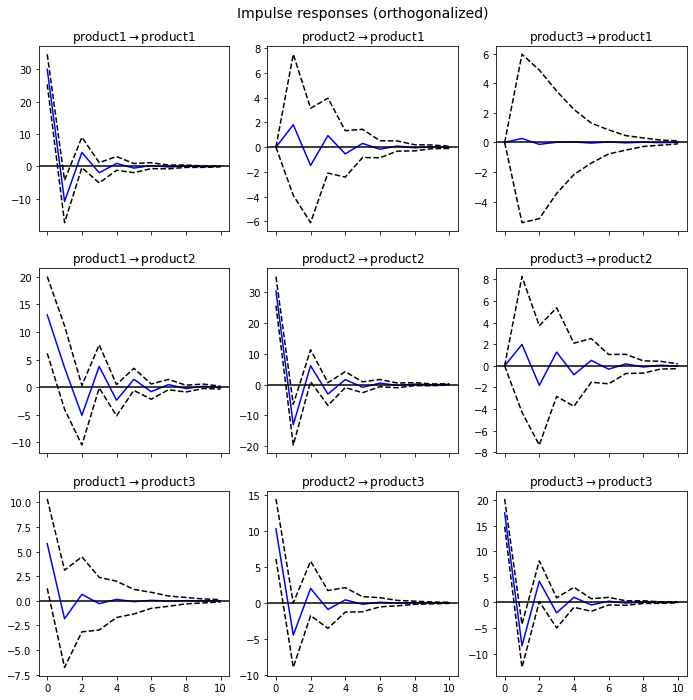

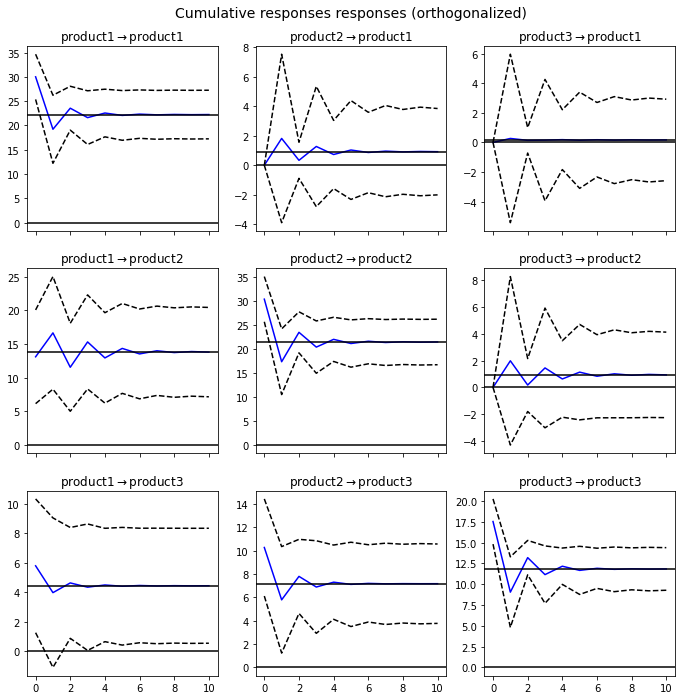

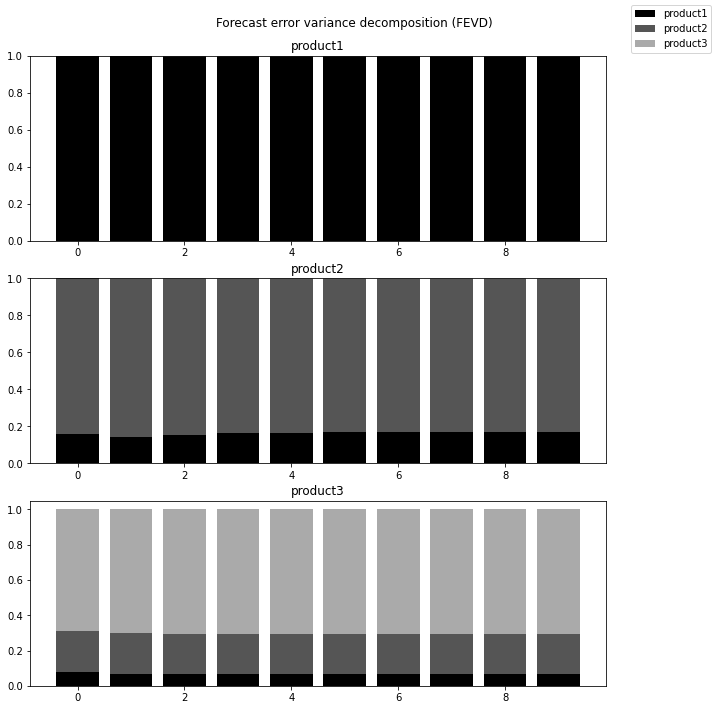

In [10]:
def structural_analyses(result):
    # impulse response analyses
    irf = result.irf(10)
    irf.plot(orth=True)
    irf.plot_cum_effects(orth=True)
    result.long_run_effects()
    result.fevd(10).plot()

structural_analyses(result)

# 4A)   
The Granger causality F-test for product 1 -> product 1 has a P-value of less than 5%. Thus we reject the null hypothesis at 5% signifiance level and conclude that product 1 Granger-cause itself.

The IRF graph shows product1 response to shock in its history for the first 4 lags before converging to 0. However, the response become statistically insignificant after lag 2 as the confidence interval after lag 2 contains the value 0.

# 4B)
The Granger causality F-test for product 1 -> product 2 is less than 5%. Thus we reject the null hypothesis at 5% signifiance level and conclude that product 1 Granger-cause product 2. 

The IRF graph shows product2 response to shock in product1’s sales for the first 6 lags before converging to 0. However, the response become statistically insignificant after lag 0.5 as the confidence interval after lag 0.5 contains the value 0.

# 4C)
The Granger causality F-test for (product1, product2) is the only one that is less than 5%. The Granger causality F-test for the other interactions (product1, product3) and (product2, product3) has a p-value of more than 5%. 

As the IRF graph of product1 -> product2 has the highest magnitudes of shock (14 units) among the three pair of interaction, the (product1, product2) pair interaction is the closest.
# 4D)
Both product1 and product2 matter in product3 prediction error as product3 FEVD contains product1 and product2. When compared to product1(10%), product2 plays a larger influence because it has a higher percentage(20%) in the product3 FEVD graph.